In [5]:
import os
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Input
from tensorflow.keras.utils import plot_model

DATA_DIR = '../../Biometrics/data/casia_gei_3'

gt = pd.read_csv(f'{DATA_DIR}/GaitDatasetB-gender.csv', delimiter='\t')


def load_gei(f, t, angle):
    for person_id in range(f, t):
        ps = str(person_id).zfill(3)
        angle = str(angle).zfill(3)
        for file in sorted(glob(f'{DATA_DIR}/{ps}_nm-*_{angle}.png')):
            gender = gt[gt['Subject ID'] == person_id].values[0][1]
            img = cv.imread(file)
            img = img.reshape((*img.shape, 1))
            yield img, person_id, int(gender == 'F')


def get_features(dataset):
    features, _, labels = [*zip(*dataset)]
    x = np.array(features)
    x = x.reshape(x.shape[:-1])
    features = tf.convert_to_tensor(x / 255, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    return features, labels


def create_model():
    model = Sequential([
        Input((224, 224, 3)),
        Conv2D(8, (3,3), activation='relu'),
        MaxPool2D(),
        Conv2D(16, (3,3), activation='relu'),
        MaxPool2D(),
        Conv2D(32, (3,3), activation='relu'),
        MaxPool2D(),
        Conv2D(64, (3,3), activation='relu'),
        MaxPool2D(),
        Flatten(),
        Dense(500, activation='relu'),
        Dense(40, activation='relu'),
        Dense(1, activation="sigmoid"),
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


angles = [90, 72, 54, 36, 18]
epochs = 100

def train_all():
    for angle in angles:
        gait_dataset = list(load_gei(1, 75, angle))
        val_dataset = list(load_gei(75, 100, angle))

        features, labels = get_features(gait_dataset)
        val_features, val_labels = get_features(val_dataset)

        dataset  = tf.data.Dataset.from_tensors((features, labels))
        val_data  = tf.data.Dataset.from_tensors((val_features, val_labels))

        model = create_model()

        hist = model.fit(dataset, epochs=epochs, batch_size=10, validation_data=val_data)

        model.save(f'nm-{angle}.keras')

        np.save(f'nm-{angle}.hist', hist.history)
        

def test_all():
    comp = []
    for angle in angles:
        test_dataset = list(load_gei(100, 125, 90))
        test_features, test_labels = get_features(test_dataset)
        print(f'Model trained with angle: {angle}')
        model = load_model(f'nm-{angle}.keras')
        yprob = model.predict(test_features)
        ypred = yprob.flatten().round()

        classes = ['M', 'F']
        print(metrics.classification_report(test_labels, ypred))
        print(metrics.confusion_matrix(test_labels, ypred))

        # pd.DataFrame(metrics.confusion_matrix(test_labels, ypred), index=classes, columns=classes).to_csv(f'nm-{angle}-confusion.csv')
        # with open(f'nm-{angle}-report.txt', 'w') as f:
            # f.write(metrics.classification_report(test_labels, ypred))

        comp.append((
            angle,
            metrics.accuracy_score(test_labels, ypred),
            metrics.precision_score(test_labels, ypred),
            metrics.recall_score(test_labels, ypred),
            metrics.f1_score(test_labels, ypred),
        ))

    # pd.DataFrame(comp, columns=['angle', 'accuracy', 'precision', 'recall', 'f1_score']).to_csv('comparison.csv', index=False)
    print('all saved sucessfully')


def plot_all():
    plot_model(create_model(), show_shapes=True, show_layer_activations=True, to_file='model.png')
    for angle in angles:
        hist = np.load(f'nm-{angle}.hist.npy', allow_pickle=True).item()
        train_loss = hist["loss"]
        val_loss = hist["val_loss"]
        train_acc = hist["accuracy"]
        val_acc = hist["val_accuracy"]
        xc = range(epochs)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(xc, train_loss, label="train")
        plt.plot(xc, val_loss, label="val")
        plt.xlabel("num of Epochs")
        plt.ylabel("loss")
        plt.title(f"train_loss vs val_loss {angle} degrees, 3 channels")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(xc, train_acc, label="train")
        plt.plot(xc, val_acc, label="val")
        plt.xlabel("num of Epochs")
        plt.ylabel("accuracy")
        plt.title(f"train_acc vs val_acc for {angle} degrees, 3 channels")
        plt.grid(True)
        plt.legend()
        plt.savefig(f"nm-{angle}.png")

        
def save_zip():
    print('!zip bio_proj.zip *.csv *.txt *.png *.npy *.keras')
    

# train_all()
# test_all()
# plot_all()

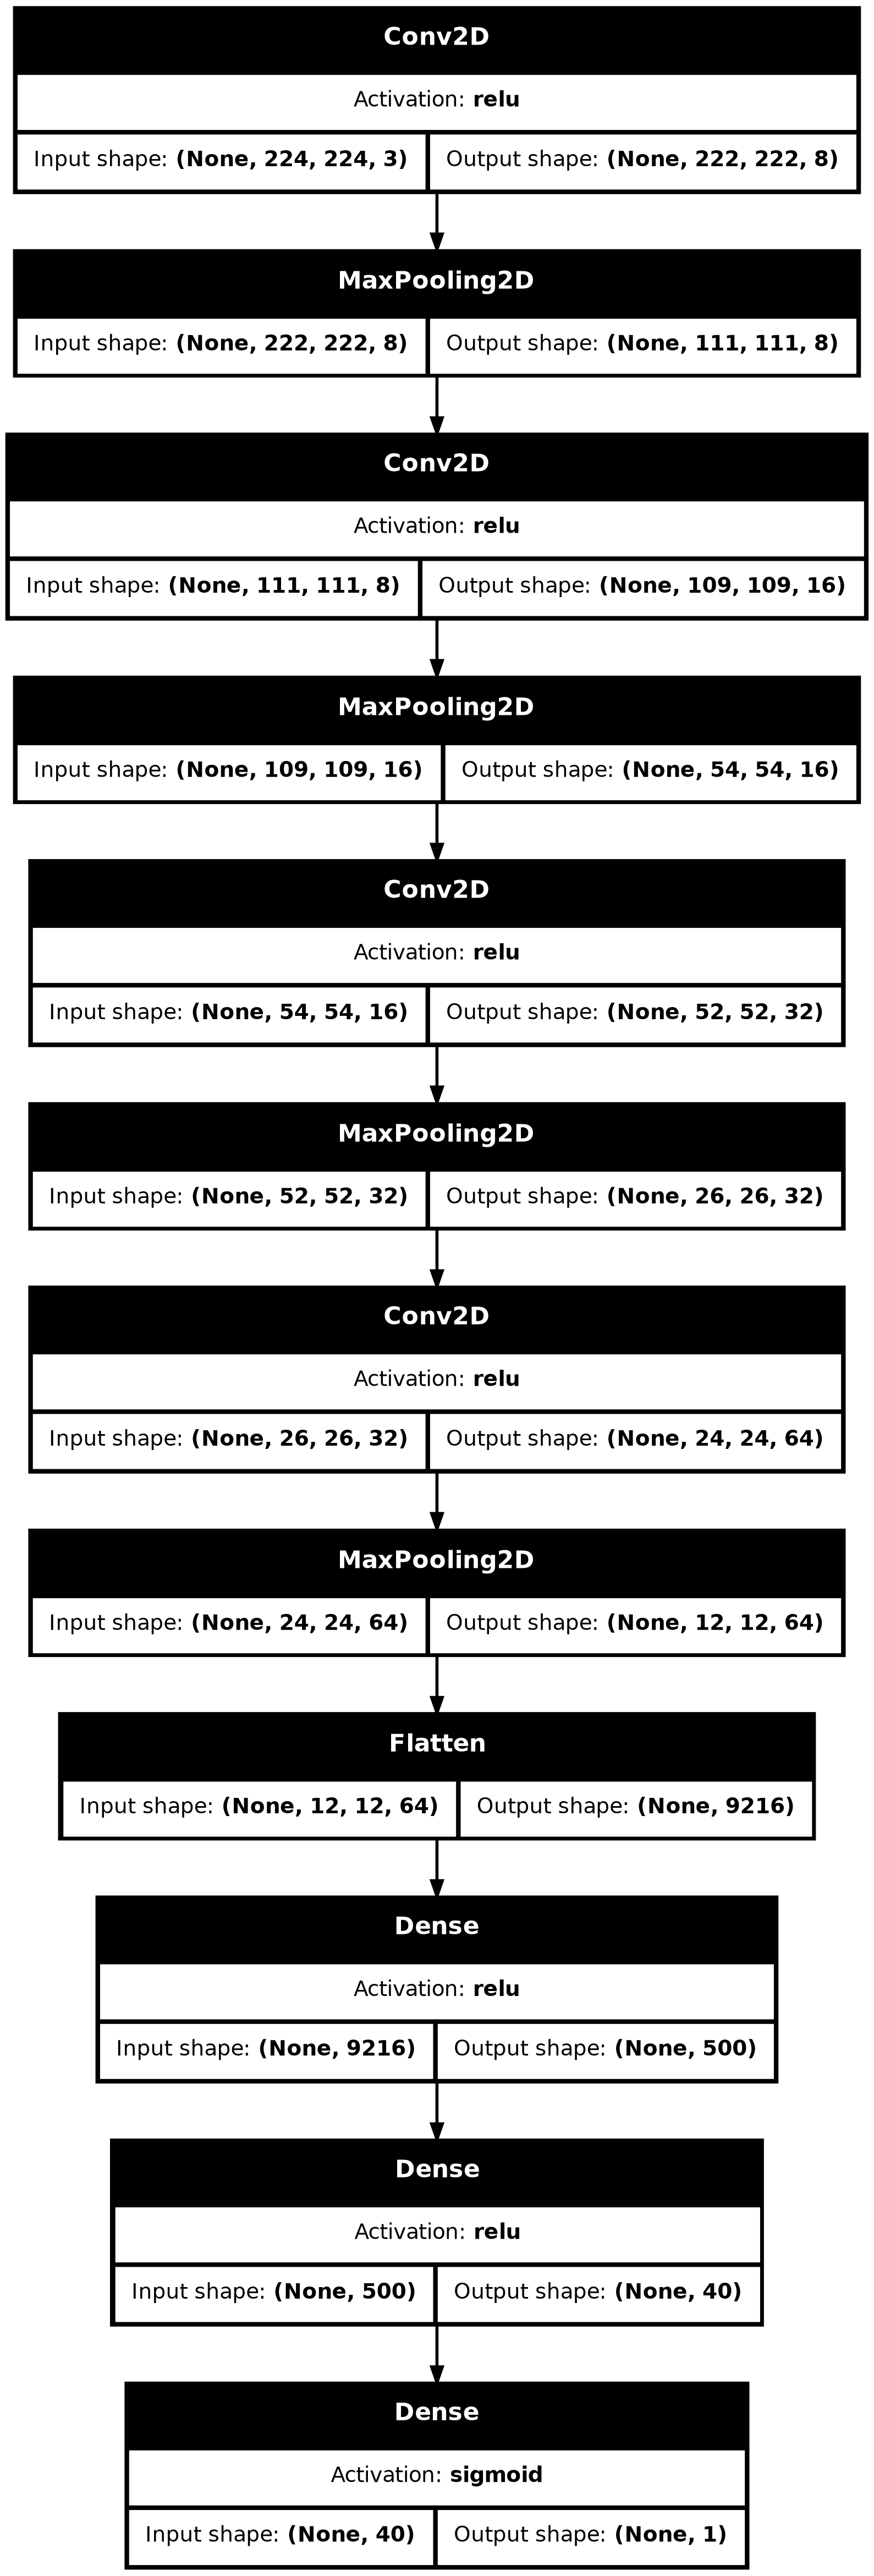

In [6]:
plot_model(create_model(), show_shapes=True, show_layer_activations=True)

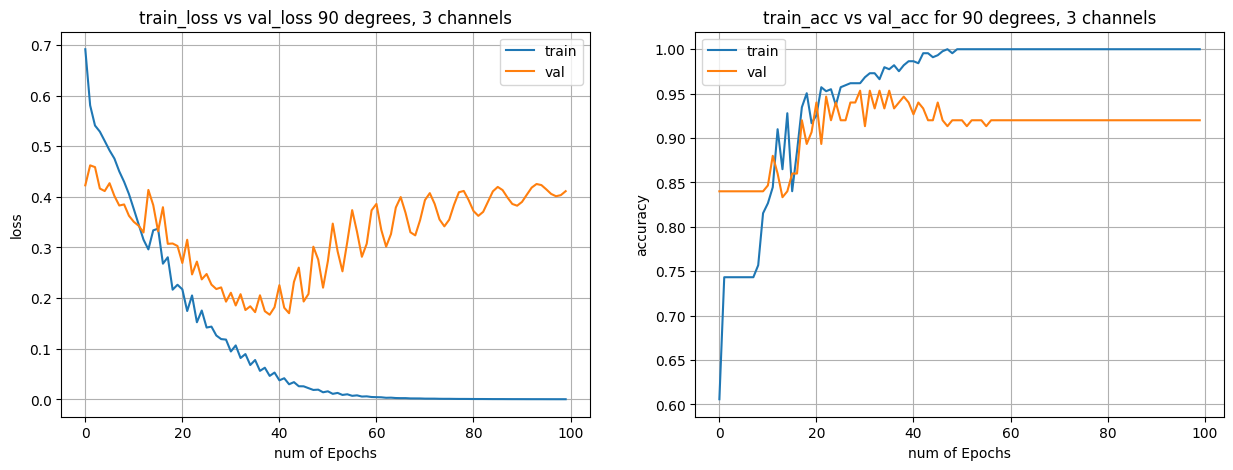

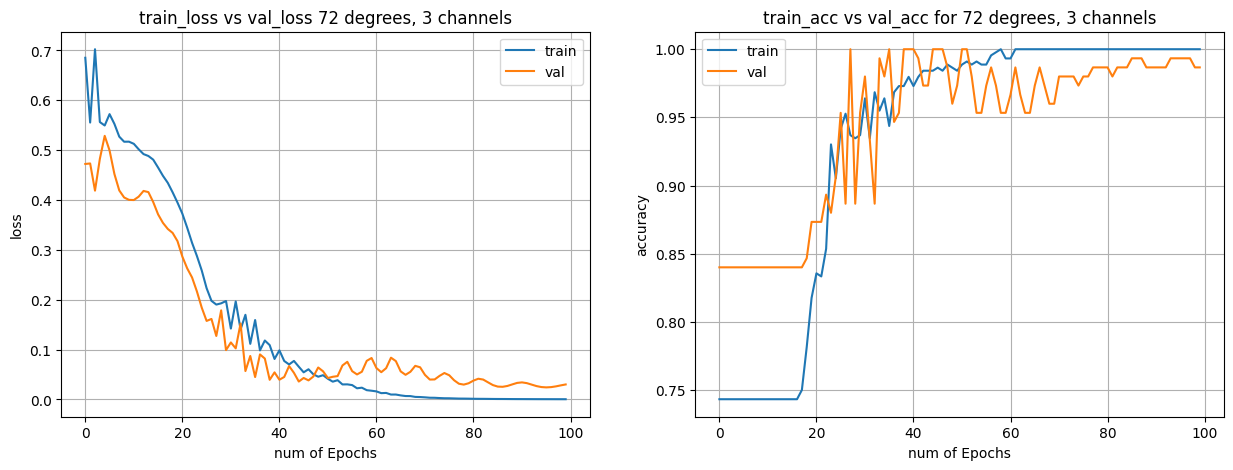

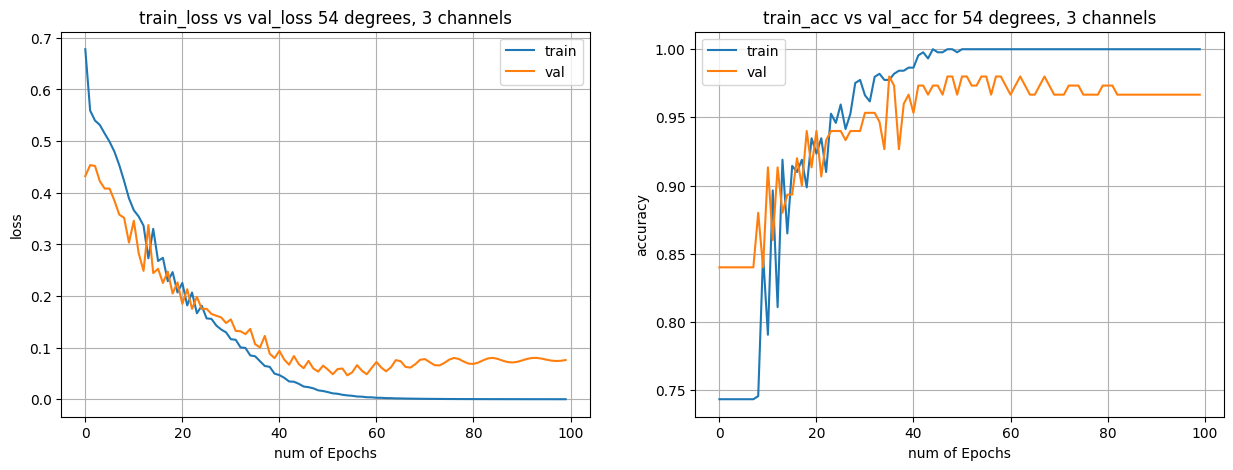

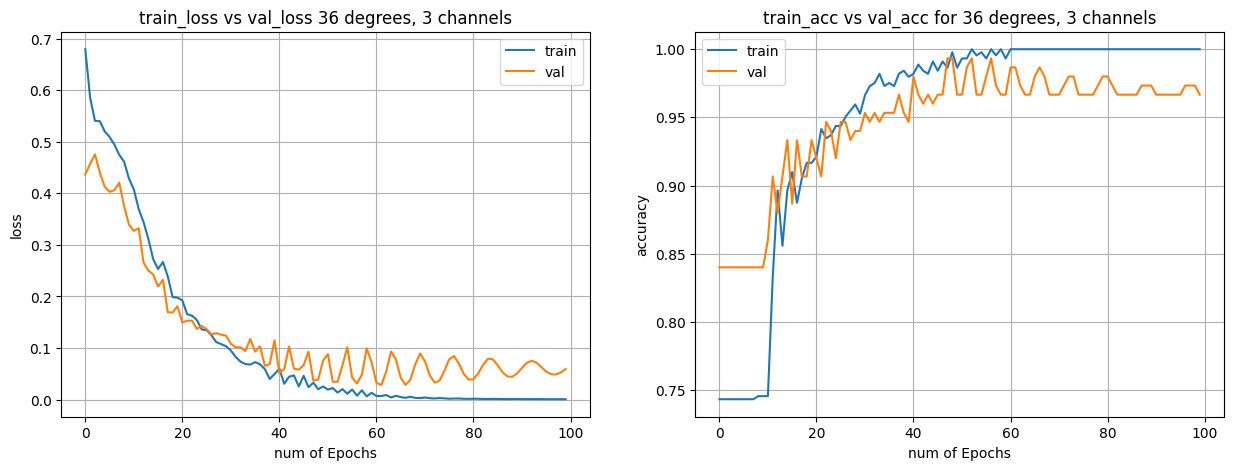

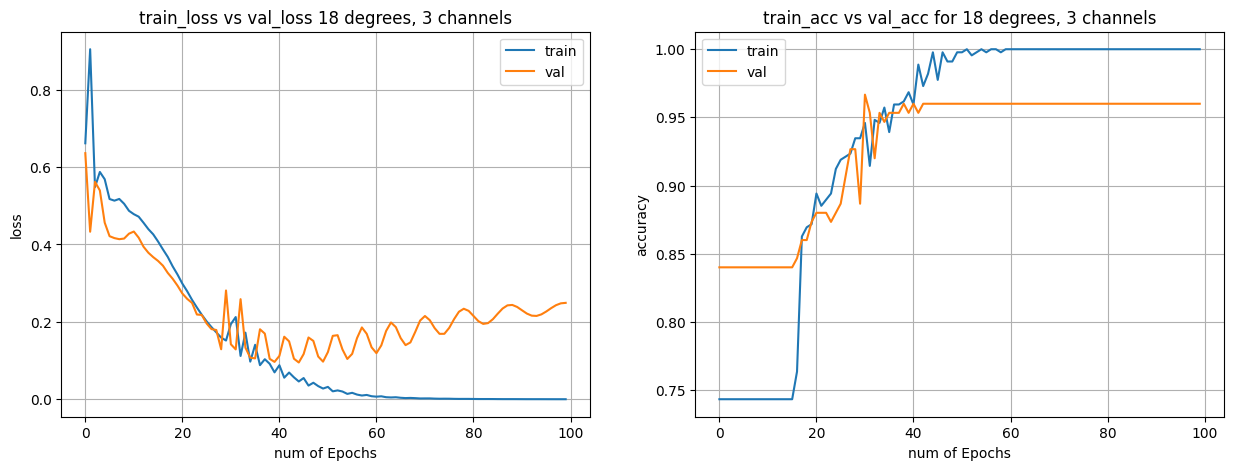

In [7]:
plot_all()

In [8]:
test_all()

Model trained with angle: 90
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       102
         1.0       1.00      0.79      0.88        48

    accuracy                           0.93       150
   macro avg       0.96      0.90      0.92       150
weighted avg       0.94      0.93      0.93       150

[[102   0]
 [ 10  38]]
Model trained with angle: 72
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87       102
         1.0       0.68      0.98      0.80        48

    accuracy                           0.85       150
   macro avg       0.83      0.88      0.84       150
weighted avg       0.89      0.85      0.85       150

[[80 22]
 [ 1 47]]
Model trained with angle: 54
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.36      0.51  